In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, BatchNormalization, Activation
)
from tensorflow.keras.models import Model


def unet_mobilenet(input_shape=(512, 512, 3), num_classes=1):
    """
    UNet model with MobileNet as the encoder backbone.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        num_classes (int): Number of output classes for segmentation.

    Returns:
        keras.Model: UNet model with MobileNet backbone.
    """
    inputs = Input(input_shape)

    mobilenet = MobileNet(input_tensor=inputs, include_top=False, weights="imagenet")

    skip1 = mobilenet.get_layer("conv_pw_1_relu").output  
    skip2 = mobilenet.get_layer("conv_pw_3_relu").output 
    skip3 = mobilenet.get_layer("conv_pw_5_relu").output 
    bottleneck = mobilenet.get_layer("conv_pw_11_relu").output  

    # Decoder: Up-sampling and concatenation
    up1 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(bottleneck)
    up1 = concatenate([up1, skip3])
    up1 = Conv2D(256, (3, 3), padding="same")(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation("relu")(up1)

    up2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(up1)
    up2 = concatenate([up2, skip2])
    up2 = Conv2D(128, (3, 3), padding="same")(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation("relu")(up2)

    up3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(up2)
    up3 = concatenate([up3, skip1])
    up3 = Conv2D(64, (3, 3), padding="same")(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation("relu")(up3)

    up4 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(up3)
    up4 = Conv2D(32, (3, 3), padding="same")(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation("relu")(up4)

    outputs = Conv2D(num_classes, (1, 1), activation="sigmoid")(up4)
    model = Model(inputs, outputs, name="UNet-MobileNet")
    return model


input_shape = (256, 256, 3)
num_classes = 1
model = unet_mobilenet(input_shape=input_shape, num_classes=num_classes)
model.summary()

Model: "UNet-MobileNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 128, 128, 32  128         ['conv1[0][0]']                  
                                )                                                    

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

# Smoothing factor to avoid division by zero
smooth = 1e-15

# Dice Coefficient
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Dice Loss
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Intersection over Union (IoU)
def iou(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Precision
def precision(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    return (true_positives + smooth) / (predicted_positives + smooth)

# Recall
def recall(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)
    return (true_positives + smooth) / (possible_positives + smooth)

# F1 Score
def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return (2. * prec * rec + smooth) / (prec + rec + smooth)

In [3]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

""" Global parameters """
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))
    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0              
    x = x.astype(np.float32)  
    x = np.expand_dims(x, axis=-1)
    return x
def tf_parse_aug(x, y):
    x, y = tf_parse(x, y)

    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_left_right(x)
        y = tf.image.flip_left_right(y)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_up_down(x)
        y = tf.image.flip_up_down(y)

    # Random rotation
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    x = tf.image.rot90(x, k)
    y = tf.image.rot90(y, k)

    # Random brightness
    x = tf.image.random_brightness(x, 0.2)
    return x, y

def tf_dataset_aug(X, Y, batch=4, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.map(tf_parse_aug, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 4
    lr = 1e-4
    num_epochs = 200
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "log.csv")

    """ Dataset """
    dataset_path = "./DATASET/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    # Use augmentation for training only
    train_dataset = tf_dataset_aug(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)


    """Model"""
    model = unet_mobilenet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),  # <- fix here
    ]


    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=1
    )

Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612
Epoch 1/200
460/460 [==============================] - ETA: 0s - loss: 0.7699 - dice_coef: 0.2301
Epoch 1: val_loss improved from inf to 0.64971, saving model to files\model.h5
460/460 [==============================] - 41s 76ms/step - loss: 0.7699 - dice_coef: 0.2301 - val_loss: 0.6497 - val_dice_coef: 0.3503 - lr: 1.0000e-04
Epoch 2/200
460/460 [==============================] - ETA: 0s - loss: 0.5642 - dice_coef: 0.4358
Epoch 2: val_loss improved from 0.64971 to 0.45820, saving model to files\model.h5
460/460 [==============================] - 34s 75ms/step - loss: 0.5642 - dice_coef: 0.4358 - val_loss: 0.4582 - val_dice_coef: 0.5418 - lr: 1.0000e-04
Epoch 3/200
460/460 [==============================] - ETA: 0s - loss: 0.4123 - dice_coef: 0.5877
Epoch 3: val_loss improved from 0.45820 to 0.36410, saving model to files\model.h5
460/460 [==============================] - 37s 81ms/step - loss: 0.4123 - dice_coef: 0.5877 - val_loss: 

In [4]:

import os

import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

""" Global parameters """
H = 256
W = 256

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Load the model """
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
        model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

    """ Dataset """
    dataset_path = "./DATASET/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
        image = cv2.resize(image, (W, H))       ## [H, w, 3]
        x = image/255.0                         ## [H, w, 3]
        x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))

        """ Prediction """
        y_pred = model.predict(x, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred >= 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = os.path.join("results", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        mask = mask/255.0
        mask = (mask > 0.5).astype(np.int32).flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/score.csv")

100%|██████████| 612/612 [02:00<00:00,  5.08it/s]

F1: 0.79509
Jaccard: 0.70668
Recall: 0.81919
Precision: 0.81514


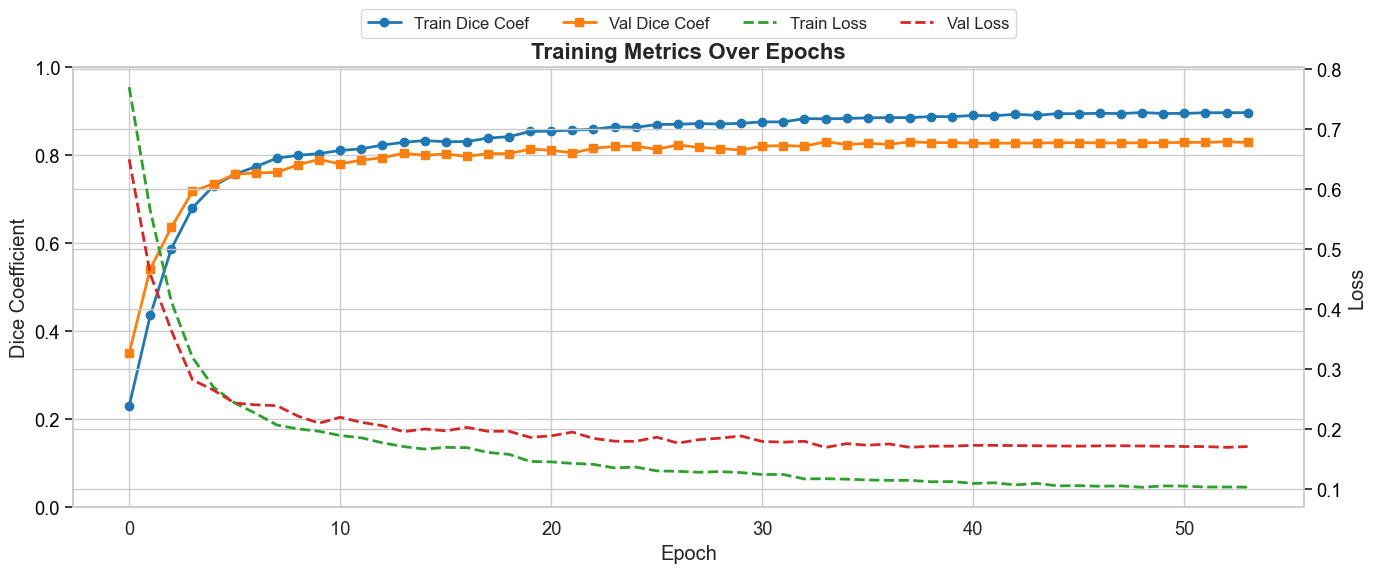

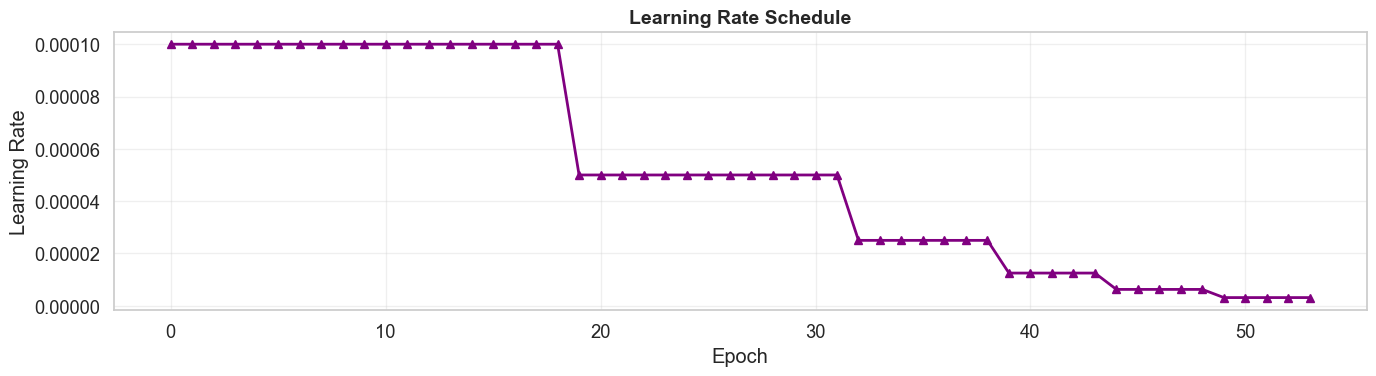

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
log = pd.read_csv("files/log.csv")

# Set a professional style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# ---------- Combined Dice & Loss Plot ----------
fig, ax1 = plt.subplots(figsize=(14, 6))

# Dice coefficient
ax1.plot(log['epoch'], log['dice_coef'], label='Train Dice Coef', color='tab:blue', marker='o', linewidth=2)
ax1.plot(log['epoch'], log['val_dice_coef'], label='Val Dice Coef', color='tab:orange', marker='s', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Dice Coefficient')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor='black')

# Loss on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(log['epoch'], log['loss'], label='Train Loss', color='tab:green', linestyle='--', linewidth=2)
ax2.plot(log['epoch'], log['val_loss'], label='Val Loss', color='tab:red', linestyle='--', linewidth=2)
ax2.set_ylabel('Loss')
ax2.tick_params(axis='y', labelcolor='black')

# Titles and legends
plt.title('Training Metrics Over Epochs', fontsize=16, fontweight='bold')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)

plt.tight_layout()
plt.show()

# ---------- Learning Rate Plot ----------
plt.figure(figsize=(14, 4))
plt.plot(log['epoch'], log['lr'], color='purple', marker='^', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


1/1 [==============================] - 4s 4s/step


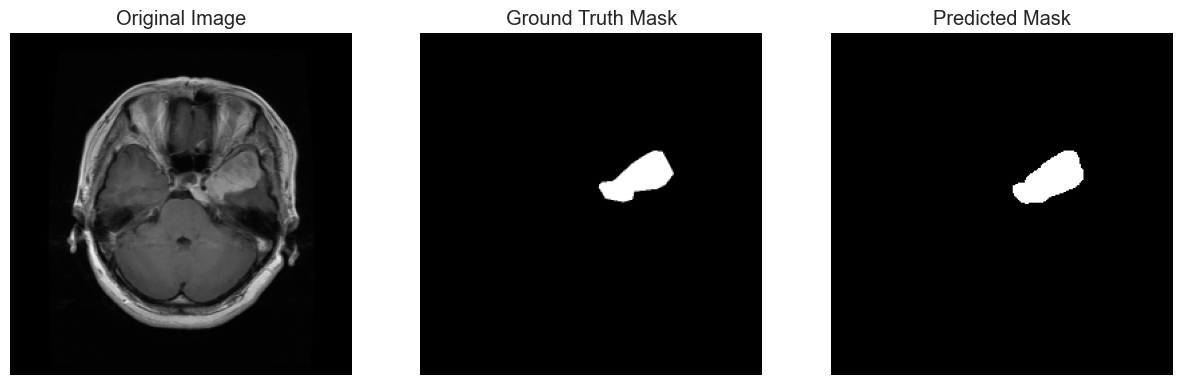

1/1 [==============================] - 0s 20ms/step


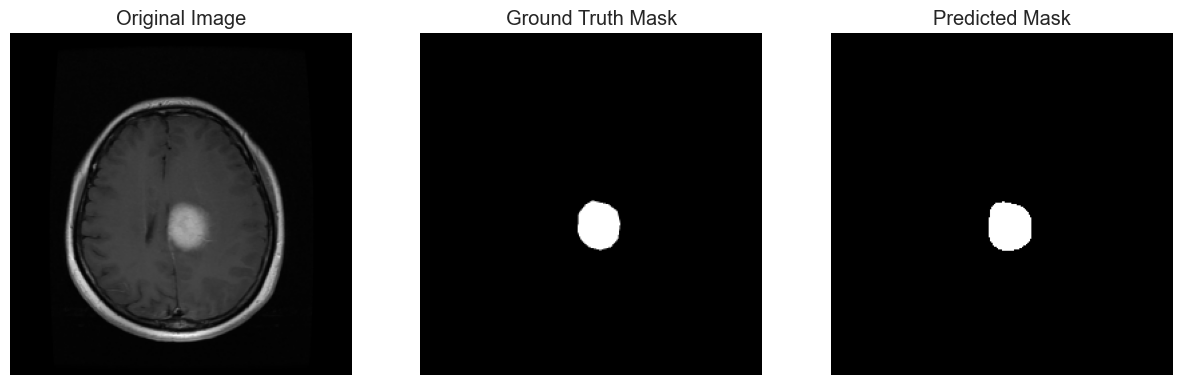

1/1 [==============================] - 0s 17ms/step


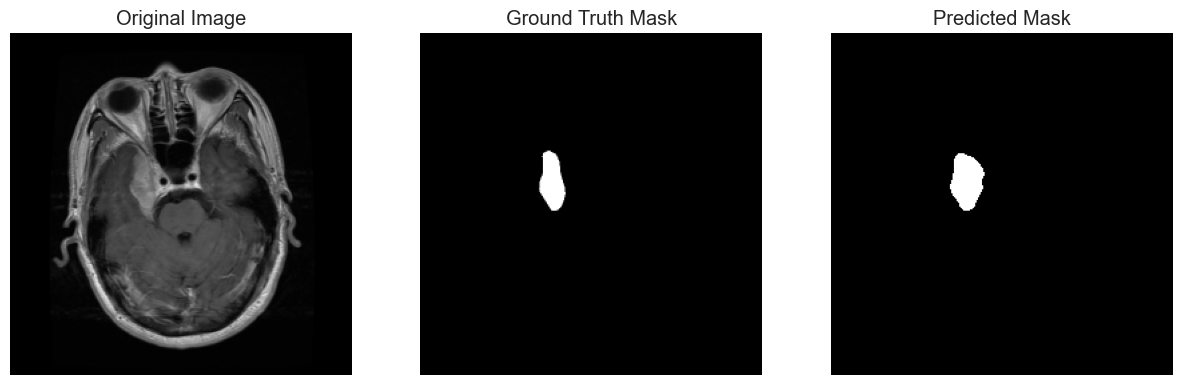

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from glob import glob  # <- Add this

# Define dice metrics and loss
smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Function to display results
def display_prediction(image, mask, prediction):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis("off")
    
    ax[2].imshow(prediction, cmap="gray")
    ax[2].set_title("Predicted Mask")
    ax[2].axis("off")
    
    plt.show()

# Load the trained model
model_path = "files/model.h5"
with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model(model_path)

# Path to dataset
dataset_path = "./DATASET/"
images = sorted(glob(os.path.join(dataset_path, "images", "*.png")))
masks = sorted(glob(os.path.join(dataset_path, "masks", "*.png")))

# Display first 3 samples
for i in range(3):
    img_path = images[i]
    mask_path = masks[i]
    
    # Read image and mask
    image = cv2.imread(img_path)
    image_resized = cv2.resize(image, (256, 256))
    x = image_resized / 255.0
    x = np.expand_dims(x, axis=0)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_resized = cv2.resize(mask, (256, 256))
    
    # Predict
    y_pred = model.predict(x)[0]
    y_pred = (y_pred > 0.5).astype(np.uint8).squeeze()
    
    # Display
    display_prediction(image_resized, mask_resized, y_pred)
